# Part 5: Iterative SCR Optimisation (ISOP)

This part iterates through lower ranked offers (2nd best, 3rd best, etc ...) to switch offers if they satisfy the gradient condition.

In [648]:
import os, sys, importlib
import pandas as pd
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '/home/jovyan/a01_repos')
import wx_tools.Wx_Utils as utl

sys.path.insert(0, '/home/jovyan/a01_repos/joe_utils')
import joe_utils.UDF_Visualisation as viz

# Project specific user-defined functions
import utl_scr_opt as udf
importlib.reload(sys.modules['utl_scr_opt'])

import utl_ipop as upop

<module 'utl_scr_opt' from '/home/jovyan/a02_projects/a06_scr_optimisation/utl_scr_opt.py'>

In [641]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Prep

In [642]:
# Load data
scored_base = pd.read_parquet('data/decision_model_base_999.parquet')
scored_base.shape
# scored_base.head(2)

(309828, 27)

In [643]:
# Initial best offers
scored_best0 = pd.read_parquet('data/decision_model_999.parquet')
scored_best = scored_best0.copy()
scored_best.shape

(5044, 28)

In [644]:
# Analysis without missing crns
# Missing crns in best offer were assigned to random group
crn_missing = list(set(scored_base['crn']) - set(scored_best['crn']))
len(crn_missing)
cond = scored_base['crn'].isin(crn_missing)

# Analysis without missing crn
scored_base = scored_base[~cond]
scored_base.shape
scored_base['crn'].nunique()
scored_best0['crn'].nunique()

560

(279114, 27)

5044

5044

## Scripting

In [636]:
score='inc_sales'
n_loop=20
i_max=None
x0=0.5
lb=[-1]
ub=[3,3]
verbose=True
out='all'

# Limit columns for efficiency
_base = scored_base[opt_cols]
_best = scored_best[opt_cols]

In [637]:
pd.options.mode.chained_assignment = None

# Intialise
opt_cols = [
    'crn', # 'offerId',
    'inc_sales', 'target_cost', 'score',
    'p_rdm', 'p_open', 'p_unsub',
]
sort_cols    = ['crn', score, 'target_cost', 'score']
sort_dir     = [True, False, True, False]
metric_cols  = ['inc_sales', 'target_cost', 'profit']
constr_cols  = ['p_rdm', 'p_open', 'p_unsub']

# Limit columns for efficiency
base = _base[opt_cols]
best = _best[opt_cols]

# Initial best offer metrics and constraints
best0_metrics = best[metric_cols[:2]].sum()
best0_metrics['profit'] = best0_metrics[0] - best0_metrics[1]
best0_constr_metrics = best[constr_cols].sum()

# Sort base by "inc_sales"; tie break on "target_cost", "score"   
base.sort_values(by=sort_cols, ascending=sort_dir, inplace=True)

# Rank and flag current best and 2nd best offers
base['rank'] = base.groupby('crn')[sort_cols[1]].rank(ascending=sort_dir[1], method='first').astype('uint8')
base['rank_best'] = 1
base['rank_2nd'] = 2
base['no_change'] = 0

# offer count per crn
offer_cnt = base.groupby('crn')['rank'].max().values
offer_cnt_explode = [[x]*x for x in offer_cnt]
base['offer_cnt'] = [x for ls in offer_cnt_explode for x in ls]
    
if i_max is None: i_max = n_loop

# -------------------------------------------------
# Iterate
# -------------------------------------------------
for i in range(3):
    
    # Top 2 offers
    cond_top2 = (base['rank'] == base['rank_best']) | (base['rank'] == base['rank_2nd'])
    top2 = base[cond_top2]

    # Top 2 diff for SC gradient
    top2_diff = top2[metric_cols[:2]] - top2.groupby('crn')[metric_cols[:2]].shift() 
    top2 = top2.merge(top2_diff, left_index=True, right_index=True, suffixes=('', '_diff'))
    top2['scr_gradient'] = top2['inc_sales_diff'] / top2['target_cost_diff']

    # Optimise gradient UB
    x_opt = optimize.fmin_cobyla(
        udf.obj_func, x0, udf.constr_ineq,
        args=(top2, best0_metrics),
        consargs=(top2, best0_constr_metrics, lb, ub)
    )
    # Select best offer
    best = udf.choose_offer(top2, x_opt)

    # Constraints (to check for violation where constraint(s) values impossible for all x)
    con = udf.constr_ineq(x_opt, top2, best0_constr_metrics, lb, ub)
    
    if verbose: print(f'iter: {i+1}, x_opt: {x_opt.round(4)}')
    
    # -------------------------------------------------
    # Update base table where best has changed
    # -------------------------------------------------
    # Check if offers still exist
    cond_offers_exist = (base['rank_2nd'] < base['offer_cnt'])

    # Check if num.offer.changes has reached limit
    crn_changes_open = base.groupby('crn')['no_change'].sum() < 5
    cond_changes_open = base['crn'].isin(crn_changes_open[crn_changes_open].index) & cond_offers_exist

    # Offer change
    cond = (best['rank'] == best['rank_2nd'])
    crn_upd = best.loc[cond, 'crn']
    cond_change = base['crn'].isin(crn_upd)

    # Update flags for crns with offer change (2nd becomes best)
    cond = cond_changes_open & cond_change
    base['rank_best'] = np.where(cond, base['rank_2nd'], base['rank_best'])
    base['rank_2nd'] = np.where(cond, base['rank_2nd']+1, base['rank_2nd'])

    # Update flags for crns with no offer change
    cond0 = cond_changes_open & ~cond_change
    cond = cond0 & (base['rank'] == base['rank_2nd'])
    base['no_change'] = np.where(cond, 1, base['no_change'])
    base['rank_2nd'] = np.where(cond0, base['rank_2nd']+1, base['rank_2nd'])

    # -------------------------------------------------
    # Terminate:
    # offers exhausted OR
    # constraints violated (impossible for all x) OR
    # iterations reached user limit
    # -------------------------------------------------
    if (cond_changes_open.sum() == 0) | np.any(con < 0) | (i+1 == i_max):
        break

iter: 1, x_opt: 1.0039
iter: 2, x_opt: 0.1572


In [639]:
con
con_rdm = ub[0] - con[0]
con_open = ub[1] - con[1]
con_unsub = lb[0] + con[2]
con2 = [con_rdm, con_open, con_unsub]
con2

array([-0.00671482,  0.6170254 ,  2.140472  ], dtype=float32)

[3.0067148208618164, 2.382974624633789, 1.1404719352722168]

In [621]:
base['crn'].nunique()
base.groupby('rank_best')['crn'].nunique().to_frame().T
ipop_best_smry = udf.get_metrics_smry(best, ['p_rdm', 'p_open', 'p_unsub'], 'avg')
ipop_best_smry.to_frame().T

5044

rank_best     1     2    3   4
crn        2921  1907  148  68

profit_avg  inc_sales_avg  target_cost_avg  p_rdm_avg  p_open_avg  \
0    1.081961        1.40078         0.318819   0.080352    0.385769   

   p_unsub_avg  
0     0.000301

## Function Execute

In [649]:
lb=[-1]; ub=[5, 5]

t_start = utl.Timer()
res = upop.ipop(scored_base, scored_best0, lb=lb, ub=ub, verbose=True)
utl.Timer(t_start)

iter: 1, x_opt: 1.0039
iter: 2, x_opt: 1.0
iter: 3, x_opt: 0.964
iter: 4, x_opt: 0.0078
iter: 5, x_opt: 0.0625
iter: 6, x_opt: 0.0
iter: 7, x_opt: 0.0
iter: 8, x_opt: 0.0
>> IPOP successful

>> Time taken: 0 hours 0 minutes and 3.78 seconds.


In [650]:
res.base['crn'].nunique()
res.base.groupby('rank_best')['crn'].nunique().to_frame()
ipop_best_smry = udf.get_metrics_smry(res.best, ['p_rdm', 'p_open', 'p_unsub'], 'avg')
ipop_best_smry.to_frame().T
ipop_best_smry = udf.get_metrics_smry(res.best, ['p_rdm', 'p_open', 'p_unsub'], 'tot')
ipop_best_smry.to_frame().T

5044

crn
rank_best      
1          2305
2          1224
3          1004
4           509
5             1
6             1

profit_avg  inc_sales_avg  target_cost_avg  p_rdm_avg  p_open_avg  \
0    1.111456       1.362454         0.250997   0.079005    0.375789   

   p_unsub_avg  
0     0.000296

profit   inc_sales  target_cost      p_rdm       p_open   p_unsub  \
0  5606.186523  6872.21582  1266.031128  398.50351  1895.480103  1.493074   

    count       scr  
0  5044.0  5.428157

In [631]:
lb=[-1]; ub=[30, 30]

t_start = utl.Timer()
res = udf.ipop(scored_base, scored_best0, lb=lb, ub=ub, verbose=True)
utl.Timer(t_start)

iter: 1, x_opt: 1.0039
iter: 2, x_opt: 1.0
iter: 3, x_opt: 1.0
iter: 4, x_opt: 1.0
iter: 5, x_opt: 1.0
iter: 6, x_opt: 1.002
iter: 7, x_opt: 1.0
iter: 8, x_opt: 0.998
iter: 9, x_opt: 1.0
iter: 10, x_opt: 1.0
iter: 11, x_opt: 0.998
iter: 12, x_opt: 1.0
iter: 13, x_opt: 1.0
iter: 14, x_opt: 1.0
iter: 15, x_opt: 1.0
iter: 16, x_opt: 1.0
>> IPOP successful

>> Time taken: 0 hours 0 minutes and 9.76 seconds.


In [632]:
res.base['crn'].nunique()
res.base.groupby('rank_best')['crn'].nunique().to_frame()
ipop_best_smry = udf.get_metrics_smry(res.best, ['p_rdm', 'p_open', 'p_unsub'], 'avg')
ipop_best_smry.to_frame().T
ipop_best_smry = udf.get_metrics_smry(res.best, ['p_rdm', 'p_open', 'p_unsub'], 'tot')
ipop_best_smry.to_frame().T

5044

crn
rank_best      
1          2297
2          1111
3           867
4           372
5           272
6            68
7            28
8            13
9            11
10            3
13            1
14            1

profit_avg  inc_sales_avg  target_cost_avg  p_rdm_avg  p_open_avg  \
0    1.123953        1.34506         0.221109   0.075114    0.366664   

   p_unsub_avg  
0     0.000291

profit    inc_sales  target_cost       p_rdm       p_open   p_unsub  \
0  5669.219727  6784.481934  1115.273071  378.873474  1849.453247  1.470101   

    count       scr  
0  5044.0  6.083247

In [388]:
InteractiveShell.ast_node_interactivity = "last"

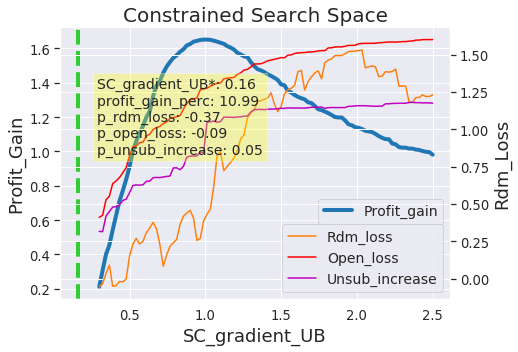

In [389]:
df_plot = pd.DataFrame(np.vstack((x, y_perc, con_rdm)).T, columns=['SC_gradient_UB', 'Profit_Gain', 'Rdm_Loss'])
x_opt = res.x_opt

# profit gain perc
y_opt = pd.DataFrame(res.rpt).iloc[0,5:6]
y_opt['p_rdm_loss'] = con_opt_rdm
y_opt['p_open_loss'] = con_opt_open
y_opt['p_unsub_increase'] = -con_opt_unsub

fig, ax, ax2 = udf.plot_dual_metrics(df_plot, x='SC_gradient_UB', y1='Profit_Gain', y2='Rdm_Loss', 
                                     line_x0=False,
                                     x_opt=x_opt, y_opt=y_opt,
                                     title='Constrained Search Space')

fig.set_size_inches(7, 5)
plt.setp(ax.lines,linewidth=4)

ax2.plot(x, con_open, 'r-', label='Open_loss')
ax2.plot(x, con_unsub, 'm-', label='Unsub_increase')
ax.legend(loc='lower right', bbox_to_anchor=(1, 0.25))
ax2.legend(loc='lower right')
plt.show()

### Top origin offer; remaining offers ordered by inc-sales

In [7]:
score = 'inc_sales'
constr_cols = ['inc_sales', 'p_rdm', 'p_open', 'p_unsub']

# Best0 constraint values
best0_constr_metrics = scored_best[constr_cols].sum()
constr_ub = [np.inf, 3, 3, -0.2]

In [111]:
# Project specific user-defined functions
import utl_scr_opt as udf
importlib.reload(sys.modules['utl_scr_opt'])

<module 'utl_scr_opt' from '/home/jovyan/a02_projects/a06_scr_optimisation/utl_scr_opt.py'>

In [7]:
# t_start = utl.Timer()
# res = ipop(scored_base, scored_best, score=score, constr_ub=constr_ub, verbose=True)
# utl.Timer(t_start)

In [112]:
t_start = utl.Timer()
res_i0 = ipop(scored_base_fix, scored_best, score=score, i_max=2, constr_ub=constr_ub, verbose=True)
utl.Timer(t_start)

iteration: 0, x_opt: -0.3281
iteration: 1, x_opt: -0.3281
iteration: 2, x_opt: -0.5
>> IPOP reached iteration limit: 2

>> Time taken: 0 hours 0 minutes and 2.54 seconds.


In [107]:
# Best profit
path_local_profit_best = 'data/decision_model_996.parquet' # tie-break on inc-sales
profit_best = pd.read_parquet(path_local_profit_best)
profit_best.shape

(5044, 29)

In [113]:
# Project specific user-defined functions
import utl_scr_opt as udf
importlib.reload(sys.modules['utl_scr_opt'])

out_type = 'avg'

# Original
best_smry = udf.get_metrics_smry(scored_best, ['p_rdm', 'p_open', 'p_unsub'], out_type)

# IPOP Full
ipop_best_smry = udf.get_metrics_smry(res.best_crn_offer, ['p_rdm', 'p_open', 'p_unsub'], out_type)

# IPOP Iteration 0
ipop_i0_best_smry = udf.get_metrics_smry(res_i0.best_crn_offer, ['p_rdm', 'p_open', 'p_unsub'], out_type)

# Best profit
best_profit_smry = udf.get_metrics_smry(profit_best, ['p_rdm', 'p_open', 'p_unsub'], out_type)

smry = pd.concat((
    best_smry.to_frame().T
    ,ipop_i0_best_smry.to_frame().T
    ,ipop_best_smry.to_frame().T
    ,best_profit_smry.to_frame().T
))
smry.index = ['current', 'profit-opt', 'IPOP', 'best-profit']
smry

<module 'utl_scr_opt' from '/home/jovyan/a02_projects/a06_scr_optimisation/utl_scr_opt.py'>

profit_avg  inc_sales_avg  target_cost_avg  p_rdm_avg  \
current        0.972210       1.402712         0.430499   0.083148   
profit-opt     1.012518       1.435035         0.422517   0.085646   
IPOP           1.022572       1.432847         0.410273   0.084439   
best-profit    1.075229       1.286833         0.211605   0.069213   

             p_open_avg  p_unsub_avg  
current        0.395527     0.000304  
profit-opt     0.396200     0.000305  
IPOP           0.394035     0.000304  
best-profit    0.358977     0.000287

### All offers ordered by inc-sales

In [8]:
scored_base_by_sales = pd.read_parquet('data/decision_model_base_999.parquet')
scored_best0 = pd.read_parquet('data/decision_model_999.parquet')

In [9]:
# Analysis without missing crns
# Missing crns in best offer were assigned to random group
crn_missing = list(set(scored_base_by_sales['crn']) - set(scored_best0['crn']))
len(crn_missing)
cond = scored_base_by_sales['crn'].isin(crn_missing)

# Analysis without missing crn
scored_base_by_sales = scored_base_by_sales[~cond]
scored_base_by_sales.shape
scored_base_by_sales['crn'].nunique()
scored_best0['crn'].nunique()

560

(279114, 27)

5044

5044

In [19]:
# Sort by score
score = 'inc_sales'
sort_cols = ['crn', score, 'target_cost', 'score']
sort_dir = [True, False, True, False]
scored_base_by_sales.sort_values(by=sort_cols, ascending=sort_dir, inplace=True)

scored_base_by_sales['rank'] = scored_base_by_sales.groupby('crn')[score].\
    rank(ascending=False, method='first').astype('uint8')
scored_base_by_sales = udf.crt_scr_gradient(scored_base_by_sales)

In [134]:
constr_cols = ['p_rdm', 'p_open', 'p_unsub']

# Best0 constraint values
best0_constr_metrics = scored_best0[constr_cols].sum()
constr_ub = [3, 3]
constr_lb = [-1]

In [200]:
# Project specific user-defined functions
import utl_scr_opt as udf
importlib.reload(sys.modules['utl_scr_opt'])

<module 'utl_scr_opt' from '/home/jovyan/a02_projects/a06_scr_optimisation/utl_scr_opt.py'>

In [199]:
t_start = utl.Timer()
res = udf.ipop(scored_base_by_sales, scored_best0, score=score, lb=constr_lb, ub=constr_ub, verbose=True)
utl.Timer(t_start)

iter: 0, x_opt: 1.0039
iter: 1, x_opt: 0.6665
iter: 2, x_opt: 0.2457
iter: 3, x_opt: 0.0149
iter: 4, x_opt: 0.0
>> IPOP successful at iteration: 4

>> Time taken: 0 hours 0 minutes and 4.79 seconds.


In [147]:
t_start = utl.Timer()
res = udf.ipop(scored_base_by_sales, scored_best0, score=score, lb=constr_lb, ub=constr_ub, verbose=True)
utl.Timer(t_start)

iter: 0, x_opt: 1.0039
iter: 1, x_opt: 0.6665
iter: 2, x_opt: 0.2457
iter: 3, x_opt: 0.0149
iter: 4, x_opt: 0.0
>> IPOP successful at iteration: 4

>> Time taken: 0 hours 0 minutes and 5.52 seconds.


In [202]:
t_start = utl.Timer()
res = udf.ipop(scored_base_by_sales, scored_best0, score=score, lb=constr_lb, ub=constr_ub, verbose=True)
utl.Timer(t_start)

iter: 0, x_opt: 1.0039
iter: 1, x_opt: 0.6665
iter: 2, x_opt: 0.2457
iter: 3, x_opt: 0.0149
iter: 4, x_opt: 0.0
>> IPOP successful at iteration: 4

>> Time taken: 0 hours 0 minutes and 4.99 seconds.


In [171]:
out_type = 'avg'

# IPOP Full
ipop_best_smry = udf.get_metrics_smry(res.best_crn_offer, ['p_rdm', 'p_open', 'p_unsub'], out_type)
ipop_best_smry.to_frame().T

profit_avg  inc_sales_avg  target_cost_avg  p_rdm_avg  p_open_avg  \
0    1.081104       1.392981         0.311877   0.080846    0.386185   

   p_unsub_avg  
0     0.000301

In [137]:
out_type = 'avg'

# IPOP Full
ipop_best_smry = udf.get_metrics_smry(res.best_crn_offer, ['p_rdm', 'p_open', 'p_unsub'], out_type)
ipop_best_smry.to_frame().T

profit_avg  inc_sales_avg  target_cost_avg  p_rdm_avg  p_open_avg  \
0     1.08331       1.391692         0.308382   0.080683    0.385508   

   p_unsub_avg  
0     0.000301

## IPOP dev
Make more efficient.

In [3]:
base0 = pd.read_parquet('data/decision_model_base_999.parquet')
best0 = pd.read_parquet('data/decision_model_999.parquet')

# Analysis without missing crns
# Missing crns in best offer were assigned to random group
crn_missing = list(set(base0['crn']) - set(best0['crn']))
cond = base0['crn'].isin(crn_missing)

# Analysis without missing crn
base0 = base0[~cond]
base0.shape

_base = base0.copy()
_best = best0.copy()

(279114, 27)

## Testing

In [58]:
import utl_scr_opt as udf
importlib.reload(sys.modules['utl_scr_opt'])

<module 'utl_scr_opt' from '/home/jovyan/a02_projects/a06_scr_optimisation/utl_scr_opt.py'>

In [59]:
# Inputs       
score       = 'inc_sales'
n_loop=100
i_max=None
verbose=False
x0=0.5
# lb=[-1]; ub=[3, 3]
lb=[-2]; ub=[2, 2]

In [60]:
lb=[-2]; ub=[3, 3]

t_start = utl.Timer()
res = udf.ipop(_base, _best, score=score, lb=lb, ub=ub, verbose=True)
utl.Timer(t_start)

iter: 0, x_opt: 1.0039
iter: 1, x_opt: 0.226
iter: 2, x_opt: 0.0
>> IPOP successful at iteration: 2

>> Time taken: 0 hours 0 minutes and 2.47 seconds.


In [65]:
res = udf.ipop(_base, _best, score=score, lb=lb, ub=ub, verbose=True, n_loop = 2)

iter: 0, x_opt: 1.0039
iter: 1, x_opt: 1.0
>> IPOP successful at iteration: 1


In [54]:
out_type = 'all'

# IPOP Full
ipop_best_smry = udf.get_metrics_smry(res.best_crn_offer, ['p_rdm', 'p_open', 'p_unsub'], out_type)
ipop_best_smry.to_frame().T

profit   inc_sales  target_cost       p_rdm       p_open   p_unsub  \
0  5442.46582  7065.96875  1623.498657  406.894501  1947.612915  1.517447   

    count      scr  profit_avg  inc_sales_avg  target_cost_avg  p_rdm_avg  \
0  5044.0  4.35231    1.078998       1.400866         0.321867   0.080669   

   p_open_avg  p_unsub_avg  
0    0.386125     0.000301

In [53]:
res.rpt

{'inc_sales_loss': array([-0.00488281], dtype=float32),
 'cost_saving': array([0.00097656], dtype=float32),
 'profit_gain': array([-0.00390625], dtype=float32),
 'inc_sales_loss_perc': array([-6.910329e-05], dtype=float32),
 'cost_saving_perc': array([6.0151695e-05], dtype=float32),
 'profit_gain_perc': array([-7.177357e-05], dtype=float32),
 'inc_sales_total': array([7065.9575], dtype=float32),
 'cost_total': array([1623.4985], dtype=float32),
 'profit_total': array([5442.459], dtype=float32),
 'count': 5044}

In [61]:
# lb=[-10]; ub=[30, 30]
lb=[-np.inf]; ub=[np.inf, np.inf]

t_start = utl.Timer()
res = udf.ipop(_base, _best, score=score, lb=lb, ub=ub, verbose=True)
utl.Timer(t_start)

iter: 0, x_opt: 1.0039
iter: 1, x_opt: 1.0
iter: 2, x_opt: 0.9922
iter: 3, x_opt: 1.0
iter: 4, x_opt: 1.0
iter: 5, x_opt: 1.0
iter: 6, x_opt: 0.5
iter: 7, x_opt: 0.5
iter: 8, x_opt: 0.5
iter: 9, x_opt: 0.5
iter: 10, x_opt: 0.5
>> IPOP successful at iteration: 10

>> Time taken: 0 hours 0 minutes and 7.04 seconds.


In [62]:
out_type = 'avg'

# IPOP Full
ipop_best_smry = udf.get_metrics_smry(res.best_crn_offer, ['p_rdm', 'p_open', 'p_unsub'], out_type)
ipop_best_smry.to_frame().T

profit_avg  inc_sales_avg  target_cost_avg  p_rdm_avg  p_open_avg  \
0    1.092011       1.390546         0.298536   0.078263    0.381202   

   p_unsub_avg  
0     0.000298